### 01 다나와에서 상품명, 스펙목록, 가격 crawling 하기

In [48]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup
from selenium.webdriver.common.by import By
from tqdm import tqdm_notebook

import pandas as pd
import numpy as np
import time

In [45]:
ser = Service('../chromedriver/chromedriver.exe')
driver = webdriver.Chrome(service = ser)

In [3]:
keyword = '무선청소기'
url = 'http://search.danawa.com/dsearch.php?k1={}&module=goods&act=dispMain'.format(keyword)
driver.get(url)

In [4]:
html = driver.page_source
soup = BeautifulSoup(html, 'html.parser')

In [5]:
item_list = soup.select('div.prod_main_info')
item = item_list[0]

In [32]:
product = item.select('.prod_info > p > a')[0].text
spec = item.select('.spec_list')[0].text.replace('\t','').replace('\n','')
price = item.select('.price_sect > a > strong')[0].text.replace(',','')
int(item.select('.price_sect > a > strong')[0].text.replace(',',''))

104990

#### 다나와사이트 크롤링하여 데이터프레임을 반환하는 함수 만들기

In [42]:
def get_product_info(keyword):
    item_list = soup.select('div.prod_main_info')
    product_list = []

    for items in item_list:
        try:
            product = items.select('.prod_info > p > a')[0].text
        except:
            pass
        
        try:
            spec = items.select('.spec_list')[0].text.replace('\t','').replace('\n','')
        except:
            pass
        
        try:
            price = int(items.select('.price_sect > a > strong')[0].text.replace(',',''))
        except:
            pass
        
        if keyword[0] in spec and '광고' not in items.text:
            product_list.append([product, spec, price])        

    product_list_pd = pd.DataFrame(product_list, columns = ['상품명', '스펙목록', '가격'])
    return product_list_pd

### 02 여러페이지에 걸친 다나와 페이지 크롤링 함수 만들기

In [ ]:
http://search.danawa.com/dsearch.php?k1=무선청소기&
    module=goods&act=dispMain

In [ ]:
http://search.danawa.com/dsearch.php?query=무선청소기&
    originalQuery=무선청소기&volumeType=allvs&page=2&limit=40&sort=saveDESC&list=list&boost=true&addDelivery=N&
    recommendedSort=Y&defaultUICategoryCode=102207&defaultPhysicsCategoryCode=72|80|81|0&defaultVmTab=2606&defaultVaTab=390097&
    tab=goods

In [ ]:
http://search.danawa.com/dsearch.php?query={}&originalQuery={}&volumeType=allvs&page={}&limit=40&sort=saveDESC&list=list&boost=true&addDelivery=N&recommendedSort=Y&defaultUICategoryCode=102207&defaultPhysicsCategoryCode=72|80|81|0&defaultVmTab=2606&defaultVaTab=390097&tab=goods

In [63]:
def get_url(page_num, keyword):
    if page_num == 1:
        url = 'http://search.danawa.com/dsearch.php?k1={}&module=goods&act=dispMain'.format(keyword)
    else:
        url = 'http://search.danawa.com/dsearch.php?query={0}&originalQuery={0}&volumeType=allvs&page={1}&limit=40&sort=saveDESC&list=list&boost=true&addDelivery=N&recommendedSort=Y&defaultUICategoryCode=102207&defaultPhysicsCategoryCode=72|80|81|0&defaultVmTab=2606&defaultVaTab=390097&tab=goods'.format(keyword, page_num)
    return url

In [72]:
def get_multi_page_crawling(total_num, keyword):   
    product_list = []
    for num in tqdm_notebook(range(1,total_num+1)):
        driver.implicitly_wait(3)
        
        driver.get(get_url(num, keyword))
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        
        item_list = soup.select('div.prod_main_info')

        for items in item_list:
            try:
                product = items.select('.prod_info > p > a')[0].text
            except:
                pass
        
            try:
                spec = items.select('.spec_list')[0].text.replace('\t','').replace('\n','')
            except:
                pass
        
            try:
                price = int(items.select('.price_sect > a > strong')[0].text.replace(',',''))
            except:
                pass
        
            if '/' in spec and '광고' not in items.text:
                product_list.append([product, spec, price])        

    product_list_pd = pd.DataFrame(product_list, columns = ['상품명', '스펙목록', '가격'])
    return product_list_pd

In [69]:
data = get_multi_page_crawling(10, '무선청소기')
data.head()

C:\Users\sara\AppData\Local\Temp/ipykernel_8148/3215115800.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for num in tqdm_notebook(range(1,total_num+1)):


  0%|          | 0/10 [00:00<?, ?it/s]

,상품명,스펙목록,가격
0,LG전자 오브제컬렉션 코드제로 ThinQ A9S AO9571,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / 소비전력: 590W...,1055260
1,삼성전자 비스포크 제트 VS20A956A3,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / [성능] 흡입력: ...,566410
2,LG전자 코드제로 ThinQ A9S AS9370IKT,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / 소비전력: 590W...,784550
3,샤오미 CLEANFLY 차량용 무선 청소기 4세대 H2 (해외구매),"차량용청소기 / 무선 / 흡입력: 16,800Pa / 최대출력: 120W / 헤파필...",59840
4,삼성전자 비스포크 제트 VS20A957E3,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / [성능] 흡입력: ...,903110


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   상품명     400 non-null    object
 1   스펙목록    400 non-null    object
 2   가격      400 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 9.5+ KB


In [71]:
data.to_excel('./files/1_danawa_crawling_result_class.xlsx', index = False)

### 03 Data Preprocessing

In [139]:
data = pd.read_excel('./files/1_danawa_crawling_result_class.xlsx')

In [140]:
data.head()

,상품명,스펙목록,가격
0,LG전자 오브제컬렉션 코드제로 ThinQ A9S AO9571,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / 소비전력: 590W...,1055260
1,삼성전자 비스포크 제트 VS20A956A3,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / [성능] 흡입력: ...,566410
2,LG전자 코드제로 ThinQ A9S AS9370IKT,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / 소비전력: 590W...,784550
3,샤오미 CLEANFLY 차량용 무선 청소기 4세대 H2 (해외구매),"차량용청소기 / 무선 / 흡입력: 16,800Pa / 최대출력: 120W / 헤파필...",59840
4,삼성전자 비스포크 제트 VS20A957E3,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / [성능] 흡입력: ...,903110


#### 상품명에서 회사명, 모델명 분리하기

In [141]:
company = data['상품명'][0].split(' ')[0]
product = ' '.join(data['상품명'][0].split(' ')[1:])

In [142]:
company_list = []
product_list = []

for item in data['상품명']:
    company_list.append(item.split(' ')[0])
    product_list.append(' '.join(item.split(' ')[1:]))

data['회사명'] = company_list
data['모델명'] = product_list
data.head()

,상품명,스펙목록,가격,회사명,모델명
0,LG전자 오브제컬렉션 코드제로 ThinQ A9S AO9571,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / 소비전력: 590W...,1055260,LG전자,오브제컬렉션 코드제로 ThinQ A9S AO9571
1,삼성전자 비스포크 제트 VS20A956A3,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / [성능] 흡입력: ...,566410,삼성전자,비스포크 제트 VS20A956A3
2,LG전자 코드제로 ThinQ A9S AS9370IKT,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / 소비전력: 590W...,784550,LG전자,코드제로 ThinQ A9S AS9370IKT
3,샤오미 CLEANFLY 차량용 무선 청소기 4세대 H2 (해외구매),"차량용청소기 / 무선 / 흡입력: 16,800Pa / 최대출력: 120W / 헤파필...",59840,샤오미,CLEANFLY 차량용 무선 청소기 4세대 H2 (해외구매)
4,삼성전자 비스포크 제트 VS20A957E3,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / [성능] 흡입력: ...,903110,삼성전자,비스포크 제트 VS20A957E3


#### 스펙목록에서 카테고리, 사용시간, 흡입력 추출해서 정리하기

In [144]:
category = data['스펙목록'][0].split(' / ')[0]
use_time = data['스펙목록'][0].split('사용시간(개당): ')[1].split(' / ')[0]
power = data['스펙목록'][0].split('흡입력: ')[1].split(' / ')[0]
print(category, use_time, power, sep = '\n')

핸디/스틱청소기
1시간
210W


In [145]:
category_list = []
use_time_list = []
power_list = []

for item in data['스펙목록']:
    try:
        category_list.append(item.split(' / ')[0])
    except:
        category_list.append(' ')
    
    try: 
        use_time_list.append(item.split('사용시간(개당): ')[1].split(' / ')[0])
    except:
        use_time_list.append(' ')
    
    try:
        power_list.append(item.split('흡입력: ')[1].split(' / ')[0])
    except:
        power_list.append(' ')
    
data['카테고리'] = category_list
data['사용시간'] = use_time_list
data['흡입력'] = power_list
data.head()

,상품명,스펙목록,가격,회사명,모델명,카테고리,사용시간,흡입력
0,LG전자 오브제컬렉션 코드제로 ThinQ A9S AO9571,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / 소비전력: 590W...,1055260,LG전자,오브제컬렉션 코드제로 ThinQ A9S AO9571,핸디/스틱청소기,1시간,210W
1,삼성전자 비스포크 제트 VS20A956A3,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / [성능] 흡입력: ...,566410,삼성전자,비스포크 제트 VS20A956A3,핸디/스틱청소기,1시간,210W
2,LG전자 코드제로 ThinQ A9S AS9370IKT,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / 소비전력: 590W...,784550,LG전자,코드제로 ThinQ A9S AS9370IKT,핸디/스틱청소기,1시간,210W
3,샤오미 CLEANFLY 차량용 무선 청소기 4세대 H2 (해외구매),"차량용청소기 / 무선 / 흡입력: 16,800Pa / 최대출력: 120W / 헤파필...",59840,샤오미,CLEANFLY 차량용 무선 청소기 4세대 H2 (해외구매),차량용청소기,,"16,800Pa"
4,삼성전자 비스포크 제트 VS20A957E3,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / [성능] 흡입력: ...,903110,삼성전자,비스포크 제트 VS20A957E3,핸디/스틱청소기,1시간,210W


 -> 위처럼 진행시 데이터 손실 발생하므로 아래 방법으로 재시도

###### 2차 시도

In [194]:
data2 = pd.read_excel('./files/1_danawa_crawling_result_class.xlsx')
data2.head()

,상품명,스펙목록,가격
0,LG전자 오브제컬렉션 코드제로 ThinQ A9S AO9571,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / 소비전력: 590W...,1055260
1,삼성전자 비스포크 제트 VS20A956A3,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / [성능] 흡입력: ...,566410
2,LG전자 코드제로 ThinQ A9S AS9370IKT,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / 소비전력: 590W...,784550
3,샤오미 CLEANFLY 차량용 무선 청소기 4세대 H2 (해외구매),"차량용청소기 / 무선 / 흡입력: 16,800Pa / 최대출력: 120W / 헤파필...",59840
4,삼성전자 비스포크 제트 VS20A957E3,핸디/스틱청소기 / 핸디+스틱형 / 무선형 / 흡입+걸레겸용 / [성능] 흡입력: ...,903110


#### 상품명에서 회사명, 모델명 분리하기

In [236]:
company_list = []
product_list = []

for item in data2['상품명']:
    company_list.append(item.split(' ')[0])
    product_list.append(' '.join(item.split(' ')[1:]))

#### 스펙목록에서 카테고리, 사용시간, 흡입력 분리하기

In [162]:
data2['스펙목록'][0].split(' / ')[5].split(': ')[1]

'210W'

In [196]:
category_list = []
use_time_list = []
power_list = []

for item in data2['스펙목록']:
    use_time = None
    power = None
    
    for spec in item.split(' / '):
        if '사용시간' in spec:
            use_time  = spec.split(': ')[1]
        if '흡입력' in spec:
            power = spec.split(': ')[1]
    
    try:
        category_list.append(item.split(' / ')[0])
    except:
        category_list.append(' ')
    
    use_time_list.append(use_time)
    power_list.append(power)

#### 무선청소기 사용시간 통일 시키기

In [203]:
use_time_list[30:40]

['10분', '20분', '25분', None, '50분', '1시간', '3시간', '1시간', '1시간', '40분']

In [204]:
time = use_time_list[33]
time

In [206]:
hour = 0
minute = 0
try:
    if '시간' in time:
        hour = int(time.split('시간')[0])
        if '분' in time:
            minute = int(time.split('시간')[1].replace('분',''))
    else:
        if '분' in time:
            minute = int(time.split('분')[0])
            hour = 0
        else:
            pass
except:
    print('none')
    
#print(time , hour*60 + minute, sep = '\n')

none


In [207]:
def convert_time_minute(time):
    hour = 0
    minute = 0
    
    try:
        if '시간' in time:
            hour = int(time.split('시간')[0])
            if '분' in time:
                minute = int(time.split('시간')[1].replace('분',''))
        else:
            if '분' in time:
                minute = int(time.split('분')[0])
                hour = 0
            else:
                return None
    except:
        return None
    
    return (hour*60 + minute)

In [215]:
new_use_time_list = []


for time in use_time_list:
    new_use_time_list.append(convert_time_minute(time))    

In [217]:
new_use_time_list[30:40]

[10, 20, 25, None, 50, 60, 180, 60, 60, 40]

In [216]:
use_time_list[30:40]

['10분', '20분', '25분', None, '50분', '1시간', '3시간', '1시간', '1시간', '40분']

#### 무선청소기 흡입력 단위 통일시키기
1W = 1AW = 100PA

In [219]:
power_list[5:15]

['20000Pa',
 '15,000Pa',
 '22000Pa',
 '210W',
 None,
 None,
 '151AW',
 '140W',
 '210W',
 '210W']

In [231]:
def convert_power(power):
    try:
        if 'Pa' in power:
            return float(power.replace(',','').replace('Pa',''))/100
        elif 'AW' in power:
            return float(power.replace(',','').replace('AW',''))
        elif 'W' in power:
            return float(power.replace(',','').replace('W',''))
    except:
        return None

In [232]:
new_power_list = []

for power in power_list:
    new_power_list.append(convert_power(power))

In [235]:
new_power_list[5:15]

[200.0, 150.0, 220.0, 210.0, None, None, 151.0, 140.0, 210.0, 210.0]

#### 전처리한 결과 통합하여 저장하기

In [237]:
pd_data = pd.DataFrame()
pd_data['카테고리'] = category_list
pd_data['회사명'] = company_list
pd_data['제품'] = product_list
pd_data['가격'] = data2['가격']
pd_data['사용시간'] = new_use_time_list
pd_data['흡입력(W)'] = new_power_list

In [238]:
pd_data.head()

,카테고리,회사명,제품,가격,사용시간,흡입력(W)
0,핸디/스틱청소기,LG전자,오브제컬렉션 코드제로 ThinQ A9S AO9571,1055260,60.0,210.0
1,핸디/스틱청소기,삼성전자,비스포크 제트 VS20A956A3,566410,60.0,210.0
2,핸디/스틱청소기,LG전자,코드제로 ThinQ A9S AS9370IKT,784550,60.0,210.0
3,차량용청소기,샤오미,CLEANFLY 차량용 무선 청소기 4세대 H2 (해외구매),59840,30.0,168.0
4,핸디/스틱청소기,삼성전자,비스포크 제트 VS20A957E3,903110,60.0,210.0


In [242]:
pd_data.to_excel('./files/2_danawa_data_final_class.xlsx', index = False)

### 04 무선 청소기 모델별 비교 분석

In [243]:
danawa_data = pd.read_excel('./files/2_danawa_data_final_class.xlsx')
danawa_data.head()

,카테고리,회사명,제품,가격,사용시간,흡입력(W)
0,핸디/스틱청소기,LG전자,오브제컬렉션 코드제로 ThinQ A9S AO9571,1055260,60.0,210.0
1,핸디/스틱청소기,삼성전자,비스포크 제트 VS20A956A3,566410,60.0,210.0
2,핸디/스틱청소기,LG전자,코드제로 ThinQ A9S AS9370IKT,784550,60.0,210.0
3,차량용청소기,샤오미,CLEANFLY 차량용 무선 청소기 4세대 H2 (해외구매),59840,30.0,168.0
4,핸디/스틱청소기,삼성전자,비스포크 제트 VS20A957E3,903110,60.0,210.0


In [245]:
top_list = danawa_data.sort_values(["흡입력(W)"], ascending = False)
top_list.head()

,카테고리,회사명,제품,가격,사용시간,흡입력(W)
370,업소용청소기,미닛츠,YS-MI2021VC,229000,NaN,1200.0
215,핸디/스틱청소기,리하스,LH20,184000,120.0,330.0
305,핸디/스틱청소기,비브르,스톰파워 VE35,235000,NaN,310.0
197,핸디/스틱청소기,아이닉,NEW i20,188000,50.0,300.0
336,핸디/스틱청소기,캐치웰,NEW F8,189000,25.0,290.0


In [246]:
top_list = danawa_data.sort_values(["사용시간"], ascending = False)
top_list.head()

,카테고리,회사명,제품,가격,사용시간,흡입력(W)
169,물걸레청소기,로엘,듀스핀2,62950,300.0,NaN
44,욕실청소기,한샘,트리플 플러스 2.0 QNBC-6000W,65010,240.0,NaN
165,물걸레청소기,로엘,듀스핀,59900,240.0,NaN
36,물걸레청소기,로엘,듀스핀3 PRO,177900,180.0,NaN
215,핸디/스틱청소기,리하스,LH20,184000,120.0,330.0


In [247]:
top_list = danawa_data.sort_values(["사용시간","흡입력(W)"], ascending = False)
top_list.head()

,카테고리,회사명,제품,가격,사용시간,흡입력(W)
169,물걸레청소기,로엘,듀스핀2,62950,300.0,NaN
44,욕실청소기,한샘,트리플 플러스 2.0 QNBC-6000W,65010,240.0,NaN
165,물걸레청소기,로엘,듀스핀,59900,240.0,NaN
36,물걸레청소기,로엘,듀스핀3 PRO,177900,180.0,NaN
215,핸디/스틱청소기,리하스,LH20,184000,120.0,330.0


In [249]:
price_mean_value = danawa_data['가격'].mean()
suction_mean_value = danawa_data['흡입력(W)'].mean()
use_time_mean_value = danawa_data['사용시간'].mean()
print("가격 평균값", price_mean_value)
print("흡입력 평균값", suction_mean_value)
print("사용시간 평균값", use_time_mean_value)

가격 평균값 296125.35
흡입력 평균값 157.364406779661
사용시간 평균값 44.98011363636363


In [251]:
condition_data = danawa_data [
    (danawa_data['가격'] <= price_mean_value) & 
    (danawa_data['흡입력(W)'] >= suction_mean_value) & 
    (danawa_data['사용시간'] >= use_time_mean_value)]
condition_data

,카테고리,회사명,제품,가격,사용시간,흡입력(W)
5,핸디/스틱청소기,샤오미,TROUVER POWER 11,73950,60.0,200.0
7,핸디/스틱청소기,샤오미,드리미 V10,155700,60.0,220.0
17,핸디/스틱청소기,델로라,V11 파워 300W,104990,70.0,220.0
23,핸디/스틱청소기,DIBEA,차이슨 ALLNEW29000,248000,48.0,290.0
28,핸디/스틱청소기,샤오미,드리미 V12,282060,90.0,270.0
29,핸디/스틱청소기,샤오미,드리미 V11,194880,90.0,250.0
34,핸디/스틱청소기,DIBEA,M24 MAX,139000,50.0,250.0
50,핸디/스틱청소기,샤오미,드리미 V11SE,180430,60.0,240.0
57,핸디/스틱청소기,샤오미,TROUVER POWER 12,169650,60.0,220.0
148,핸디/스틱청소기,샤오미,G10,256950,65.0,250.0


#### 데이터 시각화하기

In [253]:
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns
import platform

# 그래프에서 한글 표기를 위한 글꼴 변경(윈도우, macOS에 대해 처리)
font_path = ''
if platform.system() == 'Windows': 
    font_path = 'c:/Windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname = font_path).get_name()
    rc('font', family = font_name)
elif platform.system() == 'Darwin':
    font_path = '/Users/$USER/Library/Fonts/AppleGothic.ttf'
    rc('font', family = 'AppleGothic')
else: 
    print('Check your OS system')

#### 결측치(NA) 제거

In [255]:
chart_data = danawa_data.dropna(axis = 0)
len(chart_data)

212

In [257]:
suction_max_value = chart_data['흡입력(W)'].max()
suction_mean_value = chart_data['흡입력(W)'].mean()
use_time_max_value = chart_data['사용시간'].max()
use_time_mean_value = chart_data['사용시간'].mean()

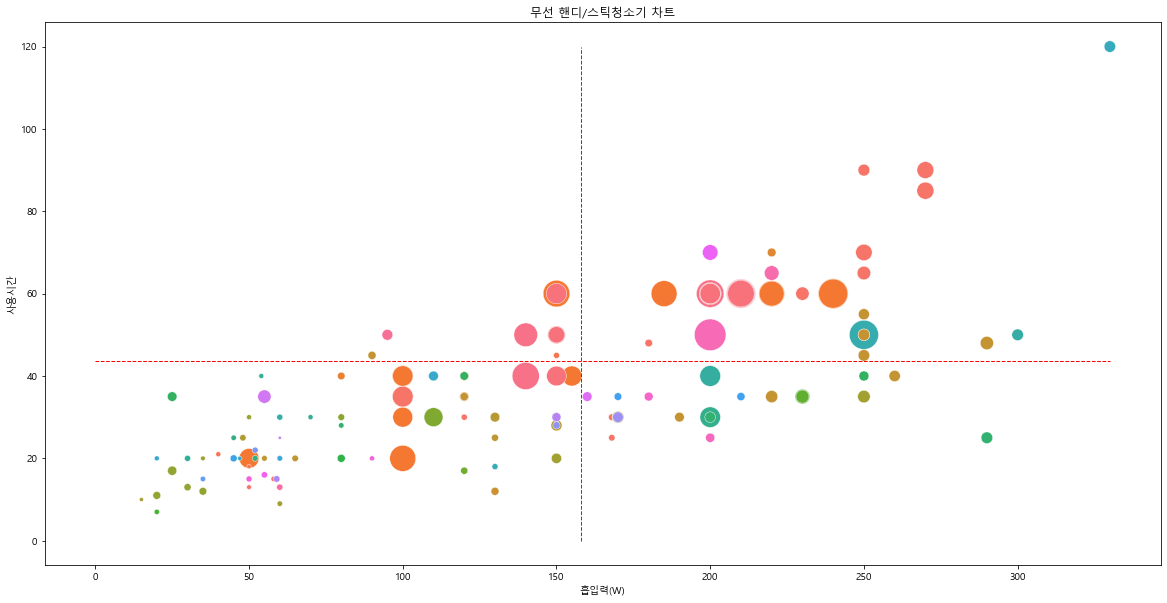

In [259]:
plt.figure(figsize=(20, 10))
plt.title("무선 핸디/스틱청소기 차트")
sns.scatterplot(x = '흡입력(W)', y = '사용시간', size = '가격', hue = chart_data['회사명'], 
             data = chart_data, sizes = (10, 1000), legend = False)
plt.plot([0, suction_max_value], 
          [use_time_mean_value, use_time_mean_value], 
          'r--', 
          lw = 1 )
plt.plot([suction_mean_value, suction_mean_value], 
          [0, use_time_max_value], 
          'r--', 
          lw = 1 )
plt.show()

#### 인기제품의 데이터 시각화

In [265]:
chart_data_selected = chart_data[:20]
chart_data_selected

,카테고리,회사명,제품,가격,사용시간,흡입력(W)
0,핸디/스틱청소기,LG전자,오브제컬렉션 코드제로 ThinQ A9S AO9571,1055260,60.0,210.0
1,핸디/스틱청소기,삼성전자,비스포크 제트 VS20A956A3,566410,60.0,210.0
2,핸디/스틱청소기,LG전자,코드제로 ThinQ A9S AS9370IKT,784550,60.0,210.0
3,차량용청소기,샤오미,CLEANFLY 차량용 무선 청소기 4세대 H2 (해외구매),59840,30.0,168.0
4,핸디/스틱청소기,삼성전자,비스포크 제트 VS20A957E3,903110,60.0,210.0
5,핸디/스틱청소기,샤오미,TROUVER POWER 11,73950,60.0,200.0
6,차량용청소기,베이스어스,차량용 청소기 A3 (해외구매),49880,45.0,150.0
7,핸디/스틱청소기,샤오미,드리미 V10,155700,60.0,220.0
8,핸디/스틱청소기,삼성전자,비스포크 제트 VS20A957D2,712970,60.0,210.0
11,핸디/스틱청소기,다이슨,V10 플러피 오리진,527450,60.0,151.0


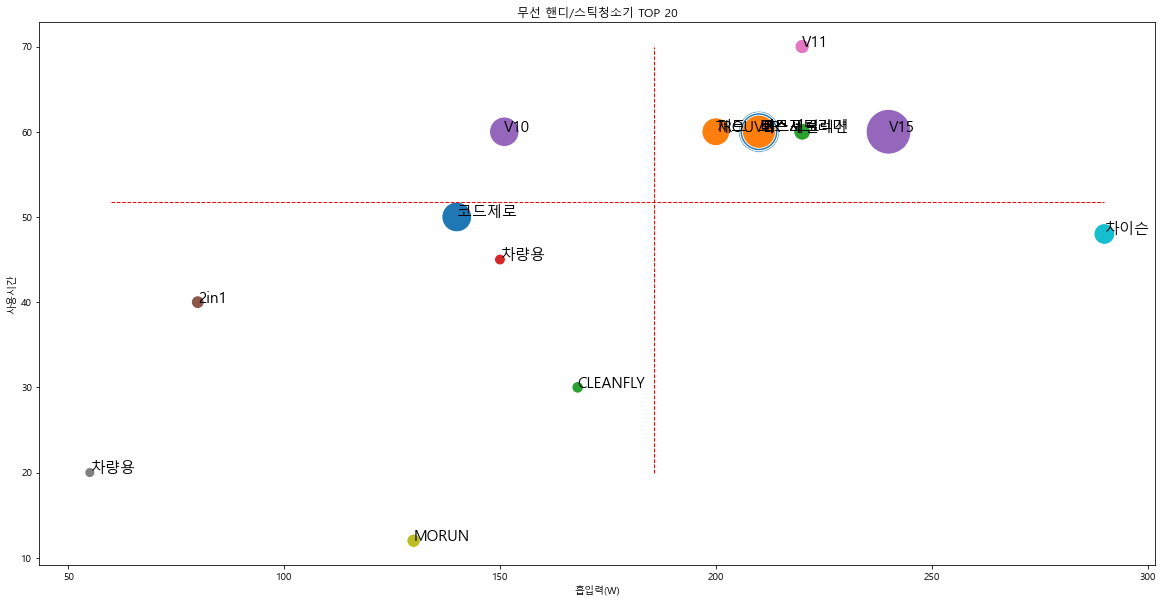

In [264]:
suction_max_value = chart_data_selected['흡입력(W)'].max()
suction_mean_value = chart_data_selected['흡입력(W)'].mean()
use_time_max_value = chart_data_selected['사용시간'].max()
use_time_mean_value = chart_data_selected['사용시간'].mean()
plt.figure(figsize=(20, 10))
plt.title("무선 핸디/스틱청소기 TOP 20")
sns.scatterplot(x = '흡입력(W)', 
                  y = '사용시간', 
                  size = '가격', 
                  hue = chart_data_selected['회사명'], 
                  data = chart_data_selected, sizes = (100, 2000),
                  legend = False)
plt.plot([60, suction_max_value], 
          [use_time_mean_value, use_time_mean_value], 
          'r--', 
          lw = 1 )
plt.plot([suction_mean_value, suction_mean_value], 
          [20, use_time_max_value], 
          'r--', 
          lw = 1 )
for index, row in chart_data_selected.iterrows():
    x = row['흡입력(W)']
    y = row['사용시간']
    s = row['제품'].split(' ')[0]
    plt.text(x, y, s, size=15)
plt.show()